In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('YourApp').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/10 07:19:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+------+
|label| count|
+-----+------+
|    1| 15952|
|    0|244912|
+-----+------+



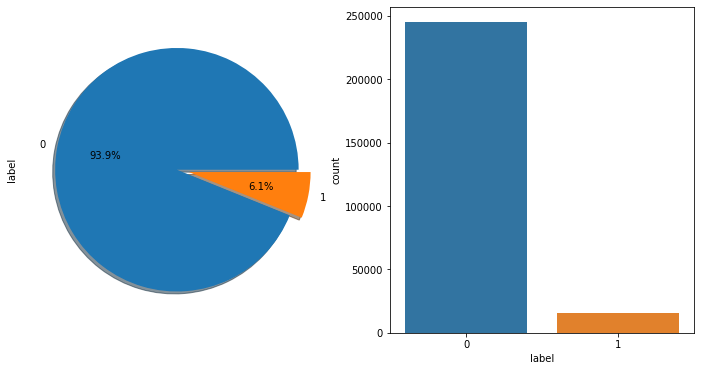

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Data Analysis').getOrCreate()

user_info = spark.read.csv('user_info_format1.csv', header=True, inferSchema=True)
user_log = spark.read.csv('user_log_format1.csv', header=True, inferSchema=True)
test_data = spark.read.csv('test_format1.csv', header=True, inferSchema=True)
train_data = spark.read.csv('train_format1.csv', header=True, inferSchema=True)

from pyspark.sql import functions as F
label_gp = train_data.groupby('label').count()
label_gp.show()

pd_train_data = train_data.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pd_train_data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=[0, 0.1], ax=axes[0])
sns.countplot(x='label', data=pd_train_data, ax=axes[1])
plt.show()

In [3]:
from pyspark.sql.functions import col, when, count

total_count = user_info.count()
missing_age_count = user_info.filter((col('age_range').isNull()) | (col('age_range') == 0)).count()
missing_age_ratio = missing_age_count / total_count
print("Missing 'age_range' ratio:", missing_age_ratio)

missing_or_zero_age_count = user_info.filter((col('age_range').isNull()) | (col('age_range') == 0)).count()
print("Count of missing or zero 'age_range':", missing_or_zero_age_count)

Missing 'age_range' ratio: 0.22427564419925974


Count of missing or zero 'age_range': 95131


In [4]:
from pyspark.sql.functions import col, when, count

total_count = user_info.count()
missing_gender_count = user_info.filter((col('gender').isNull()) | (col('gender') == 2)).count()
missing_gender_ratio = missing_gender_count / total_count
print("Missing 'gender' ratio:", missing_gender_ratio)

missing_or_two_gender_count = user_info.filter((col('gender').isNull()) | (col('gender') == 2)).count()
print("Count of missing or gender == 2:", missing_or_two_gender_count)

Missing 'gender' ratio: 0.03975292925006483
Count of missing or gender == 2: 16862


In [5]:
from pyspark.sql.functions import col

filtered_user_info = user_info.filter(~((col('age_range').isNull()) | (col('age_range') == 0)))

final_user_info = filtered_user_info.filter(~((col('gender').isNull()) | (col('gender') == 2)))

final_count = final_user_info.count()
print("Count of remaining records:", final_count)

Count of remaining records: 317840


mu = 0.07 and sigma = 0.05


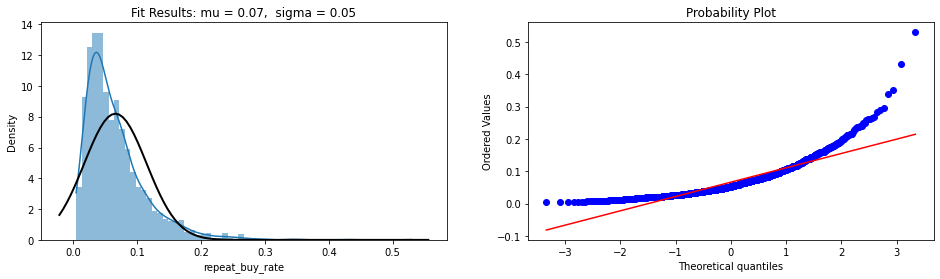

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

spark = SparkSession.builder.appName('Data Analysis').getOrCreate()

merchant_repeat_buy_df = train_data.groupBy("merchant_id").agg(mean(col("label")).alias("repeat_buy_rate"))

merchant_repeat_buy = merchant_repeat_buy_df.filter((col("repeat_buy_rate") > 0) & (col("repeat_buy_rate") <= 1)).toPandas()["repeat_buy_rate"]
plt.figure(figsize=(16, 4))
ax = plt.subplot(1, 2, 1)

sns.histplot(merchant_repeat_buy, kde=True, stat="density", linewidth=0)

(mu, sigma) = stats.norm.fit(merchant_repeat_buy)
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
ax.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  sigma = %.2f" % (mu, sigma)
ax.set_title(title)

ax = plt.subplot(1, 2, 2)
res = stats.probplot(merchant_repeat_buy, plot=plt)
plt.show()

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Data Split').getOrCreate()

splits = user_info.randomSplit([0.8, 0.2], seed=42) 
train_set = splits[0]
test_set = splits[1]

print(f"Training set size: {train_set.count()} rows")
print(f"Test set size: {test_set.count()} rows")

Training set size: 339301 rows


Test set size: 84869 rows


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Data Merge") \
    .getOrCreate()

train_data = spark.read.csv('train_format1.csv', header=True, inferSchema=True)
user_info = spark.read.csv('user_info_format1.csv', header=True, inferSchema=True)

merged_data = train_data.join(user_info, on='user_id', how='left')

merged_data.show()

+-------+-----------+-----+---------+------+
|user_id|merchant_id|label|age_range|gender|
+-------+-----------+-----+---------+------+
|  34176|       3906|    0|        6|     0|
|  34176|        121|    0|        6|     0|
|  34176|       4356|    1|        6|     0|
|  34176|       2217|    0|        6|     0|
| 230784|       4818|    0|        0|     0|
| 362112|       2618|    0|        4|     1|
|  34944|       2051|    0|        5|     0|
| 231552|       3828|    1|        5|     0|
| 231552|       2124|    0|        5|     0|
| 232320|       1168|    0|        4|     1|
| 232320|       4270|    0|        4|     1|
| 167040|        671|    0|        5|     0|
| 101760|       1760|    0|        0|     0|
| 298368|       2981|    0|        4|     0|
|  36480|       4730|    0|        6|     1|
| 299136|       2935|    0|        0|     0|
|  37248|       2615|    0|        3|     1|
| 103296|       2482|    0|        6|     0|
| 299904|       1742|    0|        6|     1|
|  38016| 

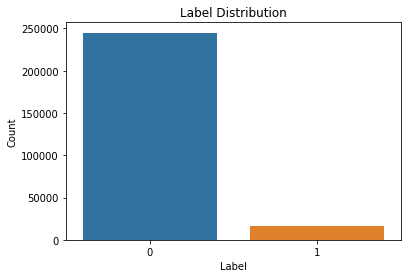

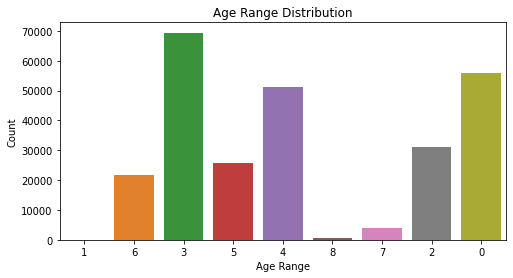

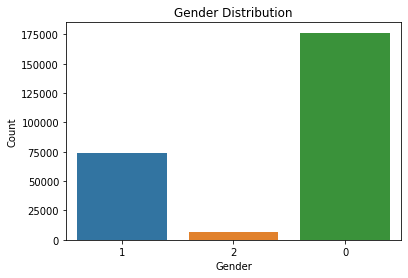

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Data Analysis") \
    .getOrCreate()


label_counts = merged_data.groupBy('label').count().collect()

plt.figure(figsize=(6, 4))
sns.barplot(x=[row['label'] for row in label_counts], y=[row['count'] for row in label_counts])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

age_range_counts = merged_data.groupBy('age_range').count().collect()

plt.figure(figsize=(8, 4))
sns.barplot(x=[row['age_range'] for row in age_range_counts], y=[row['count'] for row in age_range_counts])
plt.title('Age Range Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

gender_counts = merged_data.groupBy('gender').count().collect()

plt.figure(figsize=(6, 4))
sns.barplot(x=[row['gender'] for row in gender_counts], y=[row['count'] for row in gender_counts])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [10]:
from pyspark.sql.functions import when

user_log = user_log.withColumn('action_type', 
                               when((user_log['action_type'] == 2) | (user_log['action_type'] == 3), 1)
                               .otherwise(user_log['action_type']))

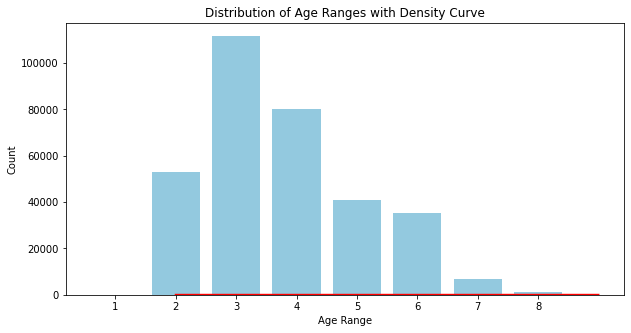

In [11]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out invalid age ranges
user_info = user_info.filter((user_info['age_range'] != 0) & (user_info['age_range'].isNotNull()))

# To use Matplotlib and Seaborn, collect the data to the driver
age_pdf = user_info.select('age_range').toPandas()

plt.figure(figsize=(10, 5))
age_counts = age_pdf['age_range'].value_counts().sort_index()
sns.barplot(x=age_counts.index, y=age_counts.values, color='skyblue')
sns.kdeplot(age_pdf['age_range'], color='red', bw_adjust=0.5, cut=0, linewidth=2)
plt.title('Distribution of Age Ranges with Density Curve')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_cols = [col for col in train_data.columns if col != 'label']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaledModel = scaler.fit(train_data)
train_data_scaled = scaledModel.transform(train_data)

train, test = train_data_scaled.randomSplit([0.7, 0.3], seed=0)

lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

lrModel = lr.fit(train)

predictions = lrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.9384920634920635
